# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission, if necessary. Sections that begin with **'Implementation'** in the header indicate where you should begin your implementation for your project. Note that some sections of implementation are optional, and will be marked with **'Optional'** in the header.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---
## Step 0: Load The Data

In [1]:
# Load pickled data
import pickle

# TODO: Fill this in based on where you saved the training and testing data

training_file = 'train.p'
testing_file = 'test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_test, y_test = test['features'], test['labels']

---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 2D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

Complete the basic data summary below.

In [2]:
### Replace each question mark with the appropriate value.

# TODO: Number of training examples
n_train = 39209

# TODO: Number of testing examples.
n_test = 12630

# TODO: What's the shape of an traffic sign image?
image_shape = (32, 32, 3)

# TODO: How many unique classes/labels there are in the dataset.
n_classes = 43

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 39209
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


Visualize the German Traffic Signs Dataset using the pickled file(s). This is open ended, suggestions include: plotting traffic sign images, plotting the count of each sign, etc.

The [Matplotlib](http://matplotlib.org/) [examples](http://matplotlib.org/examples/index.html) and [gallery](http://matplotlib.org/gallery.html) pages are a great resource for doing visualizations in Python.

**NOTE:** It's recommended you start with something simple first. If you wish to do more, come back to it after you've completed the rest of the sections.

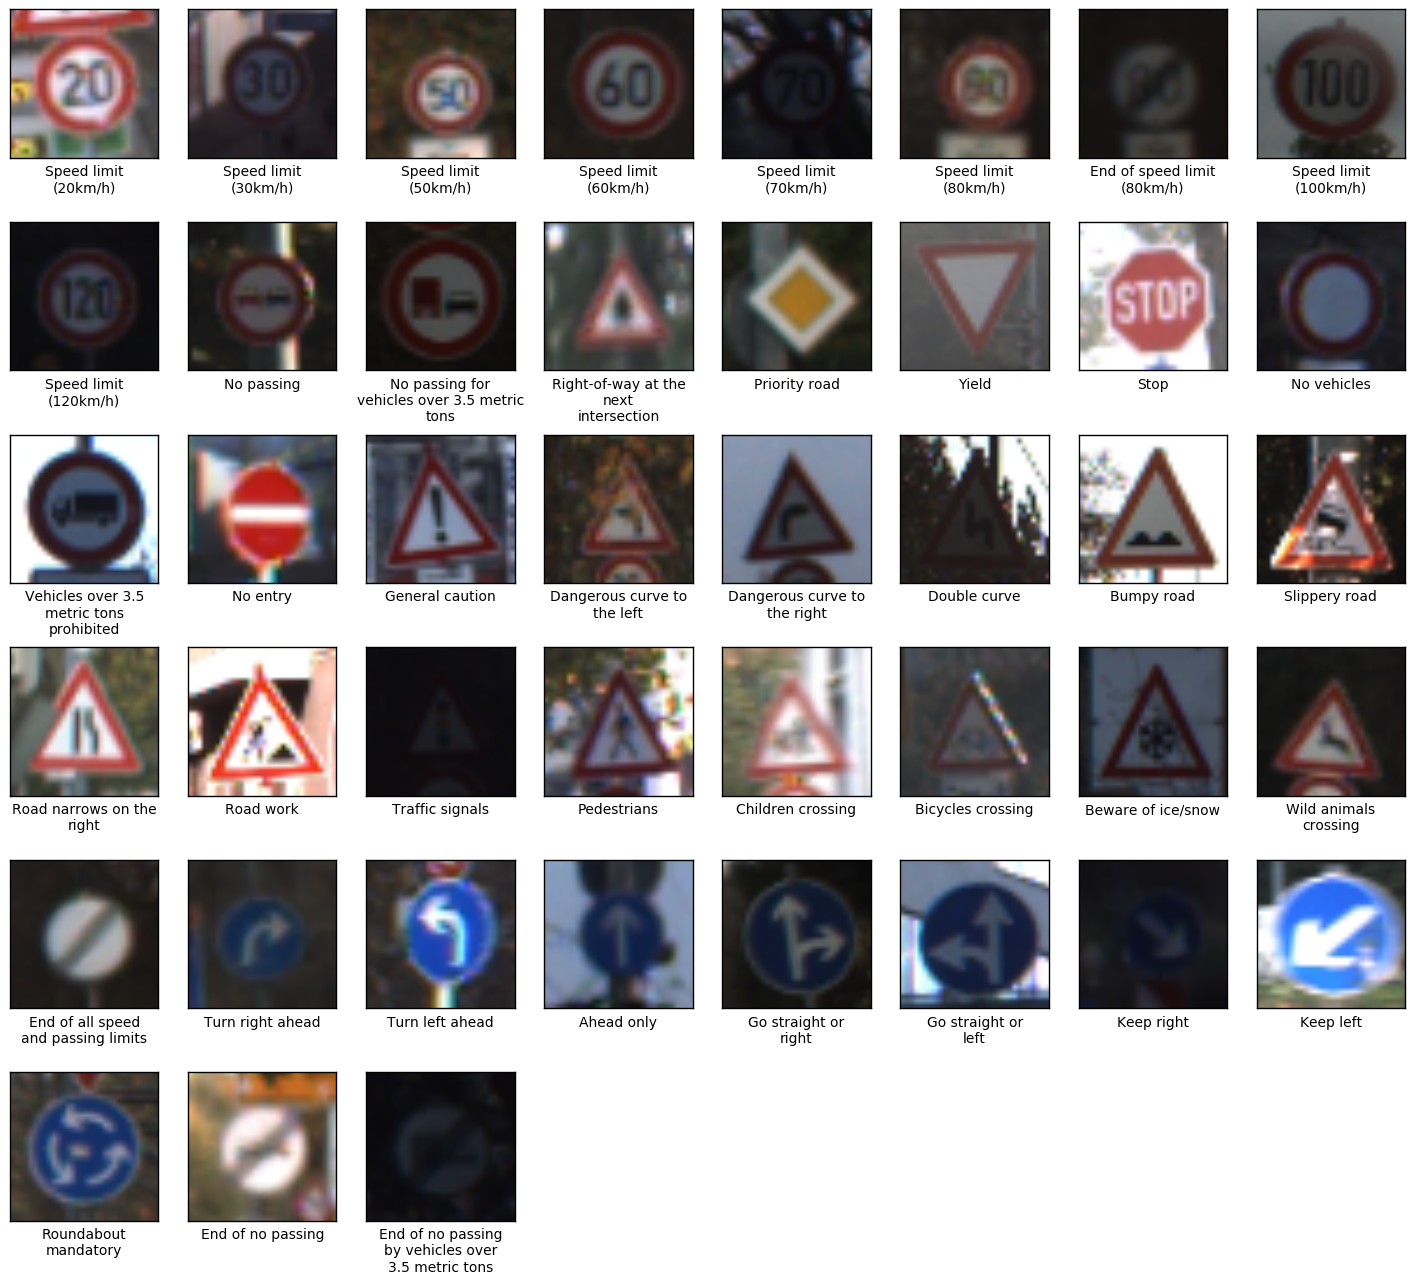

In [3]:
### Data exploration visualization goes here.
### Feel free to use as many code cells as needed.
import matplotlib.pyplot as plt
# Visualizations will be shown in the notebook.
%matplotlib inline

from collections import Counter
import numpy as np
import pandas as pd
import random

classes_id = dict(pd.read_csv('signnames.csv').values)
#print(classes_id)
c_train = Counter(y_train)
c_test = Counter(y_test)

plt.figure(figsize=(18, 16))
# plt.suptitle('Randomly selected all kinds of signs', fontsize=30)
for i in range(43):
    plt.subplot(6, 8, i+1)
    img = X_train[random.sample(np.where(y_train == i)[0].tolist(), 1)[0]]
    plt.imshow(img)
    plt.xticks([]), plt.yticks([])
    texts = classes_id[i]
    if len(texts) > 18:
        textlist = np.array(list(texts))
        blankposes = np.where(textlist == ' ')[0] 
        if len(texts) > 36:
            pos = blankposes[[np.argmin(np.abs(blankposes - 18)), 
                              np.argmin(np.abs(blankposes - 36))]]
        else:
            pos = blankposes[[np.argmin(np.abs(blankposes - 18))]]
        textlist[pos] = '\n'
        texts = ''.join(textlist)
    plt.xlabel(texts)
plt.savefig('signs.png')
plt.show()

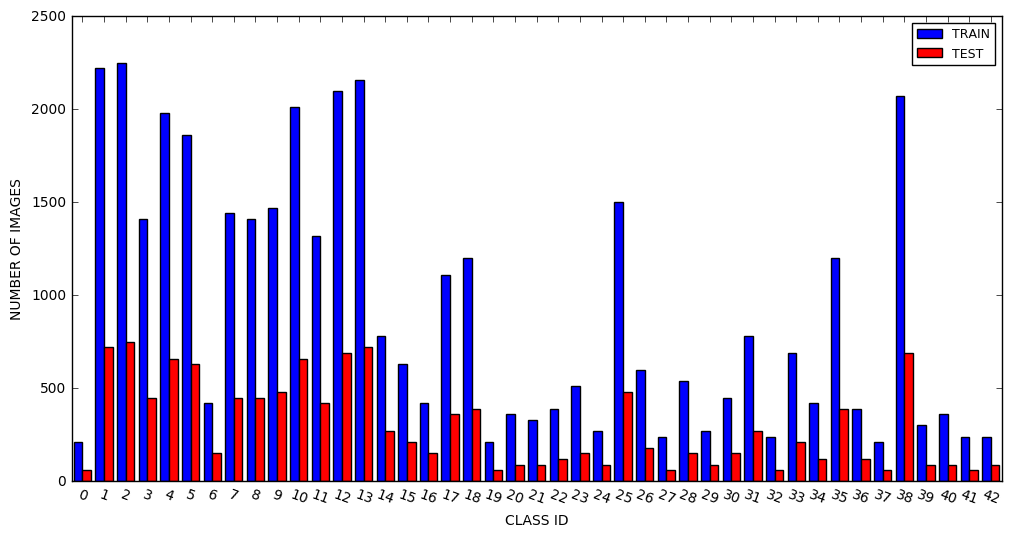

In [4]:
# plot the distribution of classes
class_idx = np.array(list(c_train.keys()))
train_samples = list(c_train.values())
test_samples = list(c_test.values())

plt.figure(figsize=(12, 6))
plt.bar(class_idx-0.4, train_samples, 0.4, color='b', label='TRAIN')
plt.bar(class_idx, test_samples, 0.4, color='r', label='TEST')
plt.xlim(-0.5, 42.5)
plt.xlabel('CLASS ID')
plt.ylabel('NUMBER OF IMAGES')
plt.xticks(class_idx, class_idx, rotation=-20)
plt.legend(fontsize=9)
plt.show()

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

There are various aspects to consider when thinking about this problem:

- Neural network architecture
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

**NOTE:** The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is a solid starting point. You'll have to change the number of classes and possibly the preprocessing, but aside from that it's plug and play!

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [5]:
### Preprocess the data here.
### Feel free to use as many code cells as needed.
import cv2

# Normalization
def image_normalize(image):
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    gray = (gray - np.mean(gray)) / (np.std(gray) + 1e-8)
    gray = np.dstack([gray]).astype(np.float32)
    return gray

X_train_p = np.array([image_normalize(img) for img in X_train])
X_test_p = np.array([image_normalize(img) for img in X_test])

# one hot encoding for labels
from sklearn.preprocessing import LabelBinarizer

one_hot = LabelBinarizer()
one_hot.fit(y_train)

y_train_p = one_hot.transform(y_train).astype(np.float32)
y_test_p = one_hot.transform(y_test).astype(np.float32)

print('Training samples shape: ', X_train_p.shape, y_train_p.shape)
print('Testing samples shape: ', X_test_p.shape, y_test_p.shape)

Training samples shape:  (39209, 32, 32, 1) (39209, 43)
Testing samples shape:  (12630, 32, 32, 1) (12630, 43)


### Question 1 

_Describe how you preprocessed the data. Why did you choose that technique?_

**Answer:**

First, the image data were converted to gray scale. This would emphasize the shape of a sign rather than its colors.

Then each image was **zero-centered** by its mean value and **normalized** by its standard deviation. Thus, normalized image pixel values will be around zero with a standard deviation of 1. 

The labels are transformed into **one-hot encodings**, for the convience of define loss function of cross entropy with softmax predictions.

In [6]:
### Generate data additional data (OPTIONAL!)
### and split the data into training/validation/testing sets here.
### Feel free to use as many code cells as needed.

# data augmentation
import tensorflow as tf
import numpy as np
from skimage.transform import rotate
from sklearn.utils import shuffle
import cv2
import random

class DataAugmentation:
    def __init__(self):
        self.img = tf.placeholder(tf.uint8, [32, 32, 3])
        self.rand_bright = tf.image.random_brightness(self.img, 0.5)
        self.rand_contra = tf.image.random_contrast(self.img, 0.5, 1.5)
        self.rand_satura = tf.image.random_saturation(self.img, 0.5, 2)
        self.rand_hue = tf.image.random_hue(self.img, 0.05)
        
    def image_process(self, sess, image,):
        rand_dos = random.randint(1, 5)
        do_seq = [True]*rand_dos + [False]*(5-rand_dos)
        do_seq = shuffle(do_seq)
        # random cropping
        if do_seq[0]: image = self.random_crop(image)
        # random brightness
        if do_seq[1]: image = sess.run(self.rand_bright, feed_dict={self.img: image})
        # random contrast
        if do_seq[2]: image = sess.run(self.rand_contra, feed_dict={self.img: image})
        # random saturation
        if do_seq[3]: image = sess.run(self.rand_satura, feed_dict={self.img: image})
        # random hue
        if do_seq[4]: image = sess.run(self.rand_hue, feed_dict={self.img: image})
        return image
        
    def random_crop(self, image):
        crop_size = random.randint(24, 32)
        offset = 32 - crop_size
        x1 = random.randint(0, offset)
        x2 = x1 + crop_size
        y1 = random.randint(0, offset)
        y2 = y1 + crop_size
        img_c = image[y1:y2, x1:x2, :]
        img_r = cv2.resize(img_c, (32, 32))
        return img_r
    
    def random_rotate(self, image):
        rand_ang = random.randint(-5, 5)
        rot = rotate(image, rand_ang)*255
        rot = rot.astype(np.uint8)
        return rot


In [7]:
# Generate augmented data
%matplotlib inline
import matplotlib.pyplot as plt
from tqdm import tqdm, tqdm_notebook

config = tf.ConfigProto()
config.gpu_options.allow_growth = True
da = DataAugmentation()
X_train_added = []
y_train_added = []
sample_adds = 2500 - np.array(train_samples)
with tf.Session(config=config) as sess:
    for i in tqdm_notebook(range(43), desc='classes'):
        pos_i = y_train == i
        imgs_i = X_train[pos_i]
        for j in tqdm_notebook(range(sample_adds[i]),
                               desc='samples', leave=False):
            rand = random.randint(0, len(imgs_i)-1)
            img = da.image_process(sess, imgs_i[rand])
            X_train_added.append(img)
            y_train_added.append(i)

X_train_added = np.array(X_train_added)
y_train_added = np.array(y_train_added)

In [8]:
X_train_augmented = np.vstack([X_train, X_train_added])
y_train_augmented = np.hstack([y_train, y_train_added])

X_train_a_p = np.array([image_normalize(img) for img in X_train_augmented])
y_train_a_p = one_hot.transform(y_train_augmented)

print(X_train_a_p.shape, y_train_a_p.shape)

(107500, 32, 32, 1) (107500, 43)


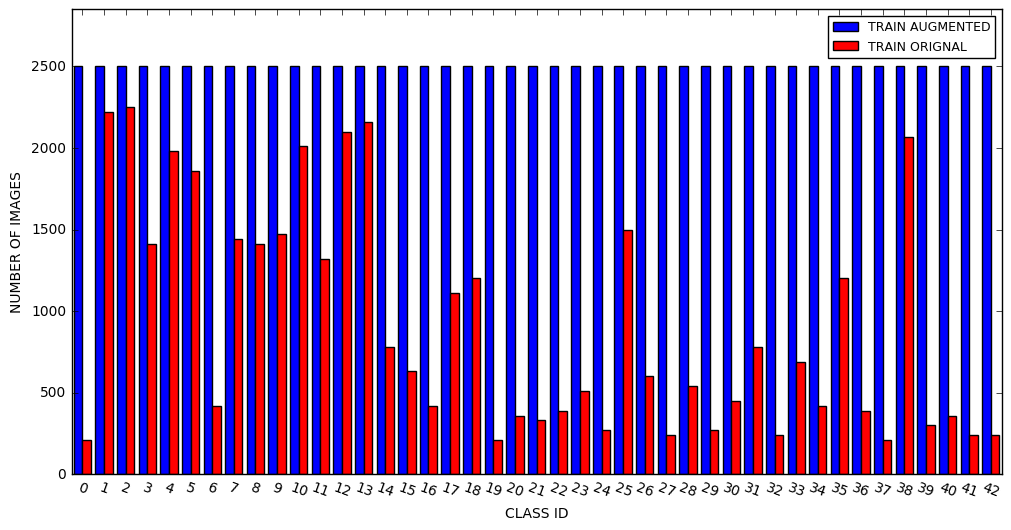

In [9]:
c_train_a = Counter(y_train_augmented)
train_a_samples = list(c_train_a.values())

plt.figure(figsize=(12, 6))
plt.bar(class_idx-0.4, train_a_samples, 0.4, color='b', label='TRAIN AUGMENTED')
plt.bar(class_idx, train_samples, 0.4, color='r', label='TRAIN ORIGNAL')
plt.xlim(-0.5, 42.5)
plt.ylim(0, 2850)
plt.xlabel('CLASS ID')
plt.ylabel('NUMBER OF IMAGES')
plt.xticks(class_idx, class_idx, rotation=-20)
plt.legend(fontsize=9)
plt.show()

In [10]:
### Generate data additional data (OPTIONAL!)
### and split the data into training/validation/testing sets here.
### Feel free to use as many code cells as needed.
from sklearn.model_selection import train_test_split

# split X_train into train/valid sets. X_test remains unchanged.
X_train_p, X_valid_p, y_train_p, y_valid_p = \
    train_test_split(X_train_p, y_train_p, test_size=0.25)

X_train_a_p, X_valid_a_p, y_train_a_p, y_valid_a_p = \
    train_test_split(X_train_a_p, y_train_a_p, test_size=0.25)

print(X_train_p.shape, y_train_p.shape)
print(X_valid_p.shape, y_valid_p.shape)
print(X_train_a_p.shape, y_train_a_p.shape)
print(X_valid_a_p.shape, y_valid_a_p.shape)
print(X_test_p.shape, y_test_p.shape)

(29406, 32, 32, 1) (29406, 43)
(9803, 32, 32, 1) (9803, 43)
(80625, 32, 32, 1) (80625, 43)
(26875, 32, 32, 1) (26875, 43)
(12630, 32, 32, 1) (12630, 43)


In [11]:
# Save the data for easy access

pickle_file = 'traffic_sign.pickle'
print('Saving original data to pickle file...')
with open(pickle_file, 'wb') as pfile:
    pickle.dump(
        {
            'train_dataset': X_train_p,
            'train_labels': y_train_p,
            'valid_dataset': X_valid_p,
            'valid_labels': y_valid_p,
            'test_dataset': X_test_p,
            'test_labels': y_test_p,
        },
        pfile, pickle.HIGHEST_PROTOCOL)
print('Original data cached in pickle file.')

pickle_file1 = 'traffic_sign_augment.pickle'
print('Saving augmented data to pickle file...')
with open(pickle_file1, 'wb') as pfile:
    pickle.dump(
        {
            'train_dataset': X_train_a_p,
            'train_labels': y_train_a_p,
            'valid_dataset': X_valid_a_p,
            'valid_labels': y_valid_a_p,
            'test_dataset': X_test_p,
            'test_labels': y_test_p,
        },
        pfile, pickle.HIGHEST_PROTOCOL)
print('Augmented data cached in pickle file.')

Saving original data to pickle file...
Original data cached in pickle file.
Saving augmented data to pickle file...
Augmented data cached in pickle file.


### Question 2

_Describe how you set up the training, validation and testing data for your model. **Optional**: If you generated additional data, how did you generate the data? Why did you generate the data? What are the differences in the new dataset (with generated data) from the original dataset?_

**Answer:**

- Testing data remains unchanged to evalute the robustness of trained models. Original training dataset are randomly splited into **train/val** parts with a proportion of 0.75/0.25. Validation dataset are used for tuning network parameters.

- Theoretically, using data augmentation techniques would increase the accurary and robustness of the model. Data augmentation methods I used include **randomly cropping, adjusting brightness, contrast, hue and saturation** for images in training dataset. Also, inbalanced number of samples for each class may also influence the training result. **Balancing** the dataset with generated data may be a good idea. Here, I expanded each class samples to a number of 2500 with generated data.


In [12]:
%matplotlib inline

# Load the modules
import pickle
import os
from tqdm import tqdm, tqdm_notebook
import numpy as np
import tensorflow as tf
import time
from sklearn.utils import shuffle
from tensorflow.contrib.layers import flatten
import pandas as pd
import random
import matplotlib.pyplot as plt

In [13]:
### Define your architecture here.
### Feel free to use as many code cells as needed.

class ClassifyNet:
    '''Basic template class to define a neural network for classification.'''
    def __init__(self):
        self._load_data()
        self._placeholders()
        self.sess = None
        self._loss()
        self._optimize()
        self.init_vars = tf.global_variables_initializer()
    
    def _placeholders(self):
        raise NotImplementedError
    
    def _net_model(self):
        raise NotImplementedError
    
    def _loss(self):
        raise NotImplementedError
    
    def _optimize(self):
        raise NotImplementedError
    
    def _evaluate(self):
        raise NotImplementedError
    
    def _load_data(self):
        raise NotImplementedError
    
    def _feed_dict(self):
        raise NotImplementedError
    
    def _start_sess(self):
        raise NotImplementedError
    
    def _reset_sess(self):
        raise NotImplementedError
    
    def train(self):
        raise NotImplementedError
    
    def evaluate_model(self):
        raise NotImplementedError
    
    def predict(self):
        raise NotImplementedError

In [14]:
class TrafficSignNet(ClassifyNet):
    
    def __init__(self, config):
        self.config = config
        self.best_save_path = os.path.join(self.config.model_path, 'best_model')
        self.final_save_path = os.path.join(self.config.model_path, 'final_model')
        ClassifyNet.__init__(self)
    
    def _placeholders(self):
        self.features = tf.placeholder(tf.float32, [None]+self.img_dims)
        self.labels = tf.placeholder(tf.float32, [None, self.n_class])
        self.keep_prob = tf.placeholder(tf.float32)
    
    def _net_model(self):
        def conv_block(name, indata, kernel_shape, stride=[1, 1, 1, 1],
                       padding='SAME', dropout=False, initializer=None):
            if initializer is None:
                w_initializer=tf.truncated_normal_initializer(mean=0, stddev=0.1)
            with tf.variable_scope(name):
                weight = tf.get_variable('conv_w', kernel_shape,
                                         initializer=initializer)
                bias = tf.get_variable('conv_b', [kernel_shape[-1]],
                                       initializer=tf.constant_initializer(0.0))
            conv = tf.nn.conv2d(indata, weight, stride, padding)
            relu = tf.nn.relu(conv + bias)
            if dropout:
                # too many dropout layer will significately slow down convergence speed.
                relu = tf.nn.dropout(relu, keep_prob=self.keep_prob)
            return relu
        
        def res_block(name, indata, kernel_shape):
            with tf.variable_scope(name):
                conv1 = conv_block(name+'_conv1', indata, kernel_shape)
                conv2 = conv_block(name+'_conv2', conv1, kernel_shape)
            res = indata + conv2
            return res
        
        def fc_block(name, indata, n_1, initializer=None):
            n_0 = indata.get_shape().as_list()[-1]
            if initializer is None:
                initializer=tf.truncated_normal_initializer(mean=0, stddev=0.1)
            with tf.variable_scope(name):
                weight = tf.get_variable('fc_w', [n_0, n_1],
                                         initializer=initializer)
                bias = tf.get_variable('fc_b', [n_1],
                                       initializer=tf.constant_initializer(0.0))
            fc = tf.matmul(indata, weight) + bias
            return fc
        
        conv1 = conv_block('conv1', self.features, [5, 5, self.img_dims[-1], 32])
        res1 = res_block('res1', conv1, [3, 3, 32, 32])
        pool1 = tf.nn.max_pool(res1, [1, 2, 2, 1], [1, 2, 2, 1], padding='SAME')
        conv2 = conv_block('conv2', pool1, [3, 3, 32, 64])
        res2 = res_block('res2', conv2, [3, 3, 64, 64])
        pool2 = tf.nn.max_pool(res2, [1, 2, 2, 1], [1, 2, 2, 1], padding='SAME')
        conv3 = conv_block('conv3', pool2, [3, 3, 64, 128])
        res3 = res_block('res3', conv3, [3, 3, 128, 128])
        fc0 = flatten(res3)
        fc1 = fc_block('fc1', fc0, 512)
        fc1 = tf.nn.relu(fc1)
        fc1 = tf.nn.dropout(fc1, keep_prob=self.keep_prob)
        fc2 = fc_block('fc2', fc1, self.n_class)
        return fc2
    
    def _loss(self):
        self.logits = self._net_model()
        self.predictions = tf.nn.softmax(self.logits)
        cross_entropy = tf.nn.softmax_cross_entropy_with_logits(self.logits, self.labels)
        train_vars = tf.trainable_variables()
        l2_loss = tf.add_n([tf.nn.l2_loss(t) for t in train_vars])
        self.loss = tf.reduce_mean(cross_entropy) + self.config.weight_decay * l2_loss
    
    def _optimize(self):
        optimizer = tf.train.AdamOptimizer(learning_rate=self.config.start_learning_rate)
        self.optimize = optimizer.minimize(self.loss)
    
    def _feed_dict(self, features, labels, keep_prob):
        feed_dict = {self.features: features, 
                     self.labels: labels, 
                     self.keep_prob: keep_prob}
        return feed_dict
    
    def _evaluate(self, X, y):
        correct_prediction = tf.equal(tf.argmax(self.logits, 1), tf.argmax(self.labels, 1))
        accuray = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
        n_samples = len(X)
        batch_size = self.config.batch_size
        total_acc = 0
        for offset in range(0, n_samples, batch_size):
            end = offset + batch_size
            X_batch, y_batch = X[offset:end], y[offset:end]
            feed_dict = self._feed_dict(X_batch, y_batch, 1.0)
            acc = self.sess.run(accuray, feed_dict=feed_dict)
            total_acc += (acc * len(X_batch)/n_samples)
        return total_acc
    
    def evaluate_model(self, X=None, y=None, model_path=None,):
        if (X is None) or (y is None):
            X = self.test_features
            y = self.test_labels
        assert X.shape[0] == y.shape[0]
        self._start_sess()
        if model_path is None:
            model_path = self.best_save_path
        assert tf.train.checkpoint_exists(model_path) is True, model_path+' does not exist!'
        self.saver.restore(self.sess, model_path)
        acc = self._evaluate(X, y)
        self.test_acc = 0
        if X is self.test_features:
            self.test_acc = acc
        print('Overall accuracy is {:.3f}%'.format(acc*100))
        self.test_all_accs = []
        for i in range(self.n_class):
            pos_i = np.where(np.argmax(y, 1) == i)[0]
            X_i = X[pos_i]
            y_i = y[pos_i]
            acc_i = self._evaluate(X_i, y_i)
            self.test_all_accs.append(acc_i)
            print('sign {:2d}: acc = {:.3f}%, number = {:d}'.format(i, acc_i*100, len(pos_i)))
        self._reset_sess()
    
    def extract_fake_predictions(self, X=None, y=None, model_path=None):
        if (X is None) or (y is None):
            X = self.test_features
            y = self.test_labels
        assert X.shape[0] == y.shape[0]
        self._start_sess()
        fake_predictions = tf.where(tf.not_equal(tf.argmax(self.predictions, 1),
                                                 tf.argmax(self.labels, 1)))
        fake_batch = []
        if model_path is None:
            model_path = self.best_save_path
        assert tf.train.checkpoint_exists(model_path) is True, model_path+' does not exist!'
        self.saver.restore(self.sess, model_path)
        n_samples = len(X)
        batch_size = self.config.batch_size
        for offset in range(0, n_samples, batch_size):
            end = offset + batch_size
            X_batch, y_batch = X[offset:end], y[offset:end]
            feed_dict = self._feed_dict(X_batch, y_batch, 1.0)
            fake = self.sess.run(fake_predictions, feed_dict=feed_dict).reshape(-1)
            if len(fake):
                fake += offset
                fake = fake.tolist()
                fake_batch += fake
        self._reset_sess()
        return fake_batch
        
    
    def train(self, fine_tuning=False, model_path=None):
        self._start_sess()
        if fine_tuning:
            if model_path is None:
                model_path = self.best_save_path    
            assert tf.train.checkpoint_exists(model_path) is True, model_path+' does not exist!'
            self.saver.restore(self.sess, model_path)
        else:
            self.sess.run(self.init_vars)
        n_train_samples = len(self.train_features)
        batch_size = self.config.batch_size
        batch_count = int(np.ceil(n_train_samples / batch_size))
        epochs = self.config.epochs
        last_best_epoch = -1
        self.loss_batch = []
        self.train_acc_batch = []
        self.valid_acc_batch = []
        for epoch in tqdm_notebook(range(self.config.epochs),
                                   desc='epoches', unit='epoch'):
            start_time = time.time()
            self.train_features, self.train_labels = shuffle(self.train_features, self.train_labels)
            for batch_i in tqdm_notebook(range(batch_count), unit='batches',
                                         desc='batches', leave=False):
                start = batch_i * batch_size
                end = start + batch_size
                features_batch = self.train_features[start:end]
                labels_batch = self.train_labels[start:end]
                batch_feed_dict = self._feed_dict(features_batch, labels_batch, 0.5)
                _, l = self.sess.run([self.optimize, self.loss],
                                     feed_dict=batch_feed_dict)
            end_time = time.time()
            speed = int(n_train_samples // (end_time - start_time))
            self.loss_batch.append(l)
            train_acc = self._evaluate(self.train_features, self.train_labels)
            self.train_acc_batch.append(train_acc)
            valid_acc = self._evaluate(self.valid_features, self.valid_labels)
            self.valid_acc_batch.append(valid_acc)
            tqdm.write('Epoch {:>2}/{}: loss = {:.2f}, train_acc = {:.3f}%, valid_acc = {:.3f}%, \
speed = {:d} image/s'.format(epoch+1, epochs, l, train_acc*100, valid_acc*100, speed))
            if (epoch+1) >= (self.config.epochs // 5):
                best_epoch = np.argmax(np.array(self.train_acc_batch) + np.array(self.valid_acc_batch))
                if best_epoch > last_best_epoch:
                    self.saver.save(self.sess, self.best_save_path)
                    tqdm.write('Save and update \
best model at epoch {:d} to {:s}'.format(best_epoch+1, self.best_save_path))
                last_best_epoch = best_epoch
        print('Best model at epoch {:d}: train_acc={:.3f}% \
valid_acc={:.3f}%'.format(best_epoch+1, 
                          self.train_acc_batch[best_epoch]*100, 
                          self.valid_acc_batch[best_epoch]*100))
        self.best_epoch = best_epoch + 1
        self.saver.save(self.sess, self.final_save_path)
        print('Save final model to {:s}'.format(self.final_save_path))
        self._reset_sess()
    
    def _start_sess(self):
        config = tf.ConfigProto()
        config.gpu_options.allow_growth = True
        self.sess = tf.Session(config=config)
        self.saver = tf.train.Saver()
    
    def _reset_sess(self):
        if self.sess is not None:
            self.sess.close()
        self.sess = None
        
    def predict(self, indata=None, model_path=None, top_k=1):
        in_shape = indata.shape
        if len(in_shape) == 4:
            assert in_shape[1:] == (32, 32, 1)
        elif len(in_shape) == 3:
            assert in_shape == (32, 32, 1)
        else:
            raise ValueError
        indata = indata.reshape(-1, 32, 32, 1)
        self._start_sess()
        if model_path is None:
            model_path = self.best_save_path
        assert tf.train.checkpoint_exists(model_path) is True, model_path+' does not exist!'
        self.saver.restore(self.sess, model_path)
        predictions = self.sess.run(self.predictions,
                                    feed_dict={self.features: indata,
                                               self.keep_prob: 1.0})
        result = self.sess.run(tf.nn.top_k(tf.constant(predictions), k=top_k))
        map_id2class = np.vectorize(lambda x: self.class_dict[x])
        top_k_class = map_id2class(result.indices)
        self._reset_sess()
        return (result.values, result.indices, top_k_class)
        
    def _load_data(self, pickle_file=None):
        if pickle_file is None:
            pickle_file = self.config.pickle_file
        with open(pickle_file, 'rb') as f:
            pickle_data = pickle.load(f)
            self.train_features = pickle_data['train_dataset']
            self.train_labels = pickle_data['train_labels']
            self.valid_features = pickle_data['valid_dataset']
            self.valid_labels = pickle_data['valid_labels']
            self.test_features = pickle_data['test_dataset']
            self.test_labels = pickle_data['test_labels']
            del pickle_data  # Free up memory
        self.img_dims = list(self.train_features.shape[1:])
        self.class_dict = dict(pd.read_csv(self.config.class_id_file).values)
        self.n_class = len(self.class_dict.keys())
        print('Training, validation, testing data loaded from {}.'.format(pickle_file))

### Question 3

_What does your final architecture look like? (Type of model, layers, sizes, connectivity, etc.)  For reference on how to build a deep neural network using TensorFlow, see [Deep Neural Network in TensorFlow
](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/b516a270-8600-4f93-a0a3-20dfeabe5da6/concepts/83a3a2a2-a9bd-4b7b-95b0-eb924ab14432) from the classroom._


**Answer:**

My architecture seems like a **mini resnet**. It consists of 9 `convolution` layers (each with an activation of `relu`), including 3 res-like blocks, and followed by 2 `FullyConnected` layers. In previous trivals, I added a `batch normalization` layer after each `convolution` layer. Since batch normalization could influence test accuracy with different batch size, I removed it. And I am still trying to figure out why.

Detailed structure is shown in the graph visualization below, using **Nvidia DIGITS** with caffe module.
![minires](mini_resnet.png)

In [15]:
class Config:
    batch_size = 256
    epochs = 100
    start_learning_rate = 0.0005
    weight_decay = 1e-6
    model_path = './models'
    pickle_file = 'traffic_sign.pickle'
    class_id_file = 'signnames.csv'

In [16]:
### Train your model here.
### Feel free to use as many code cells as needed.

tsn_config = Config()
tsn = TrafficSignNet(tsn_config)
tsn.train()

Training, validation, testing data loaded from traffic_sign.pickle.
Epoch  1/100: loss = 1.28, train_acc = 75.835%, valid_acc = 73.008%, speed = 6356 image/s
Epoch  2/100: loss = 0.58, train_acc = 93.603%, valid_acc = 91.360%, speed = 7120 image/s
Epoch  3/100: loss = 0.36, train_acc = 97.541%, valid_acc = 95.797%, speed = 7115 image/s
Epoch  4/100: loss = 0.17, train_acc = 99.031%, valid_acc = 97.501%, speed = 7118 image/s
Epoch  5/100: loss = 0.15, train_acc = 99.589%, valid_acc = 98.460%, speed = 7123 image/s
Epoch  6/100: loss = 0.11, train_acc = 99.731%, valid_acc = 98.633%, speed = 7122 image/s
Epoch  7/100: loss = 0.08, train_acc = 99.888%, valid_acc = 99.031%, speed = 7118 image/s
Epoch  8/100: loss = 0.08, train_acc = 99.956%, valid_acc = 99.072%, speed = 7119 image/s
Epoch  9/100: loss = 0.02, train_acc = 99.973%, valid_acc = 99.123%, speed = 7103 image/s
Epoch 10/100: loss = 0.04, train_acc = 99.986%, valid_acc = 99.255%, speed = 7094 image/s
Epoch 11/100: loss = 0.07, train

In [17]:
# Evaluate the best model on testing dataset
tsn.evaluate_model()

Overall accuracy is 95.653%
sign  0: acc = 100.000%, number = 60
sign  1: acc = 99.722%, number = 720
sign  2: acc = 97.600%, number = 750
sign  3: acc = 94.889%, number = 450
sign  4: acc = 97.121%, number = 660
sign  5: acc = 95.714%, number = 630
sign  6: acc = 84.667%, number = 150
sign  7: acc = 93.778%, number = 450
sign  8: acc = 95.556%, number = 450
sign  9: acc = 100.000%, number = 480
sign 10: acc = 98.333%, number = 660
sign 11: acc = 93.333%, number = 420
sign 12: acc = 98.551%, number = 690
sign 13: acc = 99.722%, number = 720
sign 14: acc = 98.148%, number = 270
sign 15: acc = 99.048%, number = 210
sign 16: acc = 100.000%, number = 150
sign 17: acc = 99.722%, number = 360
sign 18: acc = 87.949%, number = 390
sign 19: acc = 100.000%, number = 60
sign 20: acc = 100.000%, number = 90
sign 21: acc = 71.111%, number = 90
sign 22: acc = 95.833%, number = 120
sign 23: acc = 98.667%, number = 150
sign 24: acc = 84.444%, number = 90
sign 25: acc = 90.417%, number = 480
sign 26: a

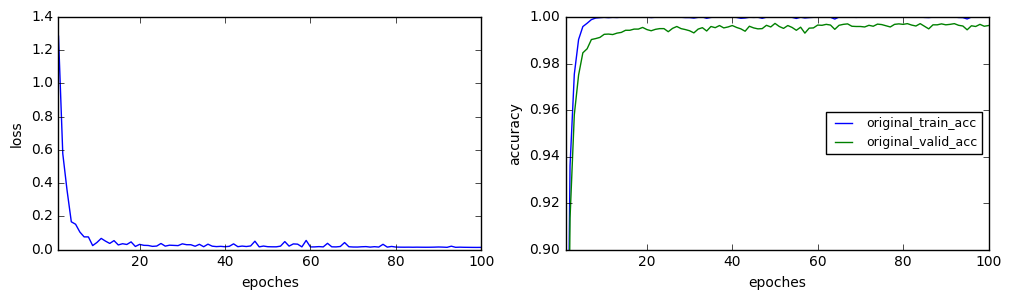

In [18]:
original_loss = tsn.loss_batch
original_train_acc = tsn.train_acc_batch
original_valic_acc = tsn.valid_acc_batch

plt.figure(figsize=(12, 3))
plt.subplot(1, 2, 1)
plt.plot(range(1, 101), original_loss)
plt.xlim(1, 100)
plt.xlabel('epoches')
plt.ylabel('loss')
plt.subplot(1, 2, 2)
plt.plot(range(1, 101), original_train_acc, label='original_train_acc')
plt.plot(range(1, 101), original_valic_acc, label='original_valid_acc')
plt.ylim(0.9, 1)
plt.xlim(1, 100)
plt.xlabel('epoches')
plt.ylabel('accuracy')
plt.legend(loc='right', fontsize=9)
plt.show()

In [19]:
# Using augmented data
tsn._load_data('traffic_sign_augment.pickle')
tsn.train(fine_tuning=True)

Training, validation, testing data loaded from traffic_sign_augment.pickle.
Epoch  1/100: loss = 0.39, train_acc = 95.986%, valid_acc = 94.999%, speed = 6835 image/s
Epoch  2/100: loss = 0.25, train_acc = 97.043%, valid_acc = 95.888%, speed = 6766 image/s
Epoch  3/100: loss = 0.20, train_acc = 97.602%, valid_acc = 96.190%, speed = 6786 image/s
Epoch  4/100: loss = 0.12, train_acc = 97.960%, valid_acc = 96.402%, speed = 7005 image/s
Epoch  5/100: loss = 0.10, train_acc = 98.117%, valid_acc = 96.346%, speed = 6809 image/s
Epoch  6/100: loss = 0.07, train_acc = 98.308%, valid_acc = 96.435%, speed = 6795 image/s
Epoch  7/100: loss = 0.17, train_acc = 98.343%, valid_acc = 96.409%, speed = 6931 image/s
Epoch  8/100: loss = 0.07, train_acc = 98.415%, valid_acc = 96.580%, speed = 6946 image/s
Epoch  9/100: loss = 0.14, train_acc = 98.431%, valid_acc = 96.517%, speed = 7016 image/s
Epoch 10/100: loss = 0.11, train_acc = 98.402%, valid_acc = 96.428%, speed = 6891 image/s
Epoch 11/100: loss = 0.0

In [20]:
tsn.evaluate_model()

Overall accuracy is 97.165%
sign  0: acc = 100.000%, number = 60
sign  1: acc = 99.722%, number = 720
sign  2: acc = 99.600%, number = 750
sign  3: acc = 97.111%, number = 450
sign  4: acc = 97.879%, number = 660
sign  5: acc = 96.667%, number = 630
sign  6: acc = 78.667%, number = 150
sign  7: acc = 96.000%, number = 450
sign  8: acc = 96.000%, number = 450
sign  9: acc = 100.000%, number = 480
sign 10: acc = 99.091%, number = 660
sign 11: acc = 95.952%, number = 420
sign 12: acc = 97.101%, number = 690
sign 13: acc = 99.444%, number = 720
sign 14: acc = 100.000%, number = 270
sign 15: acc = 100.000%, number = 210
sign 16: acc = 100.000%, number = 150
sign 17: acc = 96.111%, number = 360
sign 18: acc = 88.462%, number = 390
sign 19: acc = 100.000%, number = 60
sign 20: acc = 100.000%, number = 90
sign 21: acc = 100.000%, number = 90
sign 22: acc = 93.333%, number = 120
sign 23: acc = 94.667%, number = 150
sign 24: acc = 98.889%, number = 90
sign 25: acc = 96.250%, number = 480
sign 26

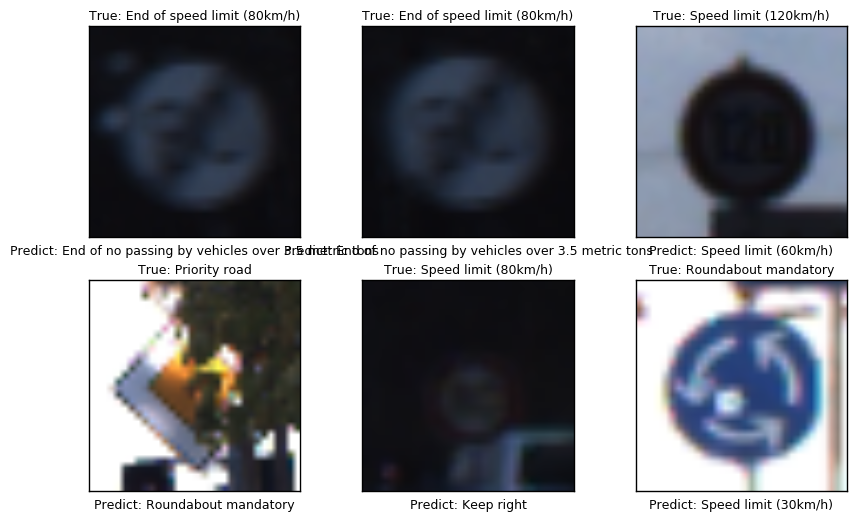

In [21]:
# fake detections visualization

fake_tests = tsn.extract_fake_predictions(tsn.test_features, tsn.test_labels)
chosen = random.sample(fake_tests, 6)
plt.figure(figsize=(10, 6))
for n, i in enumerate(chosen):
    plt.subplot(2, 3, n+1)
    plt.imshow(X_test[i])
    plt.title('True: '+tsn.class_dict[y_test[i]], fontsize=9)
    img = image_normalize(X_test[i])
    predict = tsn.predict(img)[2][0][0]
    plt.xlabel('Predict: '+predict, fontsize=9)
    plt.xticks([]), plt.yticks([])
plt.show()

### Question 4

_How did you train your model? (Type of optimizer, batch size, epochs, hyperparameters, etc.)_


**Answer:**

My neural network was trained on my PC with a Nvidia GTX 1080 card.

In training the original training dataset, I used an **adam optimizer with an initial learning rate of 0.0005**, and the **l2 loss decay factor is 1e-6**. The weights are initalize with a stddev of 0.01. Since the GPU has 8G GDDR5 RAM, I set batch size as 256. Training epochs were 100, with a total time cost of about 10 minutes.

I then fine tuned the best model with the augmented data. Since the augmented data samples increased, total training time was then about 26 minutes.

### Question 5


_What approach did you take in coming up with a solution to this problem? It may have been a process of trial and error, in which case, outline the steps you took to get to the final solution and why you chose those steps. Perhaps your solution involved an already well known implementation or architecture. In this case, discuss why you think this is suitable for the current problem._

**Answer:**

Tuning hyperparameters took a lot of trials and errors. In my first trivals, I didn't notice that **weight initialization** is of great importance. Weights inital values with a stddev of 1 are too large, so as to leading loss value going to `NaN` after several layer computations. And also, with big weights inital values, learning rate can't be set to large values. After setting weights inital values with a stddev of 0.1, the issue was gone. I also tried batch normalization layers after convolution layers, as it is said that they can accelerate training speed and regularize results. It took me a whole day to find out that batch normalization could influence testing results with different batch size. Thus, I removed this layer, but I am still figuring it out by trying to understand the math behind.

As shown in above cells for training process. I found that data augmentation works. The overall testing accuracy increased from 0.9566 to 0.9717, especially for some signs with a few samples. However, since data augmentation can also introduce some noises, the accuracy on some class of signs decreased a little. Some testing samples still with not good enough accuracy is probablely that they have some kind of features different from the training dataset, and even from the augmented data.

Since train_acc=100.000% and valid_acc=99.725% at the best model shows that my convnet indeed learned something. Anyway, the model may needs further training with proper data augmentation or some preprocessing techniques.

---

## Step 3: Test a Model on New Images

Take several pictures of traffic signs that you find on the web or around you (at least five), and run them through your classifier on your computer to produce example results. The classifier might not recognize some local signs but it could prove interesting nonetheless.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

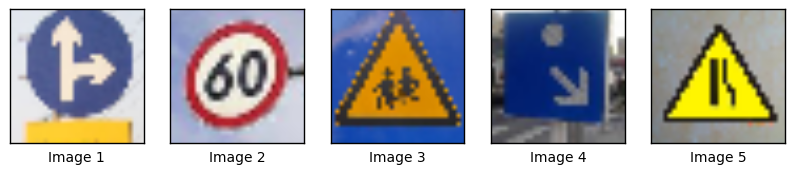

In [22]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.
import matplotlib.image as mpimage
import cv2

real_imgs = []
for i in range(5):
    img = mpimage.imread(str(i+1)+'.jpg')
    img = cv2.resize(img, (32, 32))
    real_imgs.append(img)
real_imgs = np.array(real_imgs)

plt.figure(figsize=(10, 2))
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.imshow(real_imgs[i])
    plt.xticks([]), plt.yticks([])
    plt.xlabel('Image '+str(i+1))
plt.show()

### Question 6

_Choose five candidate images of traffic signs and provide them in the report. Are there any particular qualities of the image(s) that might make classification difficult? It could be helpful to plot the images in the notebook._



**Answer:**

In my first trivals, training dataset were not converted to grayscale, thus making the model also learn the color distribution of a sign. When testing on those signs with similar shape but different colors from the training dataset, the result went wrong.

In [23]:
### Run the predictions here.
### Feel free to use as many code cells as needed.
imgs_p = np.array([image_normalize(img) for img in real_imgs])
result = tsn.predict(imgs_p)
for i, sign in enumerate(result[2]):
    print('Image {}: {}'.format(i+1, sign[0]))

Image 1: Go straight or right
Image 2: Speed limit (60km/h)
Image 3: Children crossing
Image 4: Keep right
Image 5: Road narrows on the right


### Question 7

_Is your model able to perform equally well on captured pictures when compared to testing on the dataset? The simplest way to do this check the accuracy of the predictions. For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate._

_**NOTE:** You could check the accuracy manually by using `signnames.csv` (same directory). This file has a mapping from the class id (0-42) to the corresponding sign name. So, you could take the class id the model outputs, lookup the name in `signnames.csv` and see if it matches the sign from the image._


**Answer:**

The predictions on captured pictures are correct, the accuracy is 100%, which seems better than that of testing dataset with a value of 97.17%, though the number of captured samples is just too few. Anyway, as long as captured pictures have similar features compared to training dataset, the predictions should be just fine.

In [26]:
### Visualize the softmax probabilities here.
### Feel free to use as many code cells as needed.
result = tsn.predict(imgs_p, top_k=3)
print('certainties :', result[0])
print('predictions :', result[1])
print('sign names  :', result[2])

certainties : [[  1.00000000e+00   1.24474414e-36   0.00000000e+00]
 [  1.00000000e+00   2.21371743e-09   4.46461072e-14]
 [  1.00000000e+00   1.49522226e-08   1.37767883e-23]
 [  1.00000000e+00   1.64794270e-21   6.47466789e-22]
 [  1.00000000e+00   0.00000000e+00   0.00000000e+00]]
predictions : [[36 33  0]
 [ 3  0 35]
 [28 30 29]
 [38  2 40]
 [24  0  1]]
sign names  : [['Go straight or right' 'Turn right ahead' 'Speed limit (20km/h)']
 ['Speed limit (60km/h)' 'Speed limit (20km/h)' 'Ahead only']
 ['Children crossing' 'Beware of ice/snow' 'Bicycles crossing']
 ['Keep right' 'Speed limit (50km/h)' 'Roundabout mandatory']
 ['Road narrows on the right' 'Speed limit (20km/h)' 'Speed limit (30km/h)']]


### Question 8

*Use the model's softmax probabilities to visualize the **certainty** of its predictions, [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. Which predictions is the model certain of? Uncertain? If the model was incorrect in its initial prediction, does the correct prediction appear in the top k? (k should be 5 at most)*

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

Take this numpy array as an example:

```
# (5, 6) array
a = np.array([[ 0.24879643,  0.07032244,  0.12641572,  0.34763842,  0.07893497,
         0.12789202],
       [ 0.28086119,  0.27569815,  0.08594638,  0.0178669 ,  0.18063401,
         0.15899337],
       [ 0.26076848,  0.23664738,  0.08020603,  0.07001922,  0.1134371 ,
         0.23892179],
       [ 0.11943333,  0.29198961,  0.02605103,  0.26234032,  0.1351348 ,
         0.16505091],
       [ 0.09561176,  0.34396535,  0.0643941 ,  0.16240774,  0.24206137,
         0.09155967]])
```

Running it through `sess.run(tf.nn.top_k(tf.constant(a), k=3))` produces:

```
TopKV2(values=array([[ 0.34763842,  0.24879643,  0.12789202],
       [ 0.28086119,  0.27569815,  0.18063401],
       [ 0.26076848,  0.23892179,  0.23664738],
       [ 0.29198961,  0.26234032,  0.16505091],
       [ 0.34396535,  0.24206137,  0.16240774]]), indices=array([[3, 0, 5],
       [0, 1, 4],
       [0, 5, 1],
       [1, 3, 5],
       [1, 4, 3]], dtype=int32))
```

Looking just at the first row we get `[ 0.34763842,  0.24879643,  0.12789202]`, you can confirm these are the 3 largest probabilities in `a`. You'll also notice `[3, 0, 5]` are the corresponding indices.

**Answer:**

For all the images, the model classified correctly with strong certainty.

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.